In [22]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    cohen_kappa_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    confusion_matrix,
    make_scorer,
)


# Input preparation

## Read fingerprint file and experimental file

In [ ]:
# Load the data
fingerprints = pd.read_csv(
    "../data/PsychLight/PsychLight_MACCS_fingerprints.csv"
)
labels = pd.read_csv("../data/PsychLight/PsychLight_TrainingSet.csv")

X = fingerprints.drop(columns=['ID']).iloc[:, 1:]
y = labels['Class']
print(X.shape, y.shape)
print(X.head())

(54, 166) (54,)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    0    1    0    1    1    1    1    0   
2  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    0    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 166 columns]
0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64


# Training

## Random Forest Classification: Optuna + Nested CV

In [29]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-07 15:34:09,198] A new study created in memory with name: no-name-5c1853a5-09a3-4602-9e4c-9ad17916f077


[I 2025-01-07 15:34:09,301] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 31, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-01-07 15:34:09,366] Trial 1 finished with value: 0.6916666666666667 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 0.6916666666666667.
[I 2025-01-07 15:34:09,597] Trial 2 finished with value: 0.7138888888888888 and parameters: {'n_estimators': 67, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 2 with value: 0.7138888888888888.
[I 2025-01-07 15:34:09,879] Trial 3 finished with value: 0.6694444444444445 and parameters: {'n_estimators': 87, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 2 with value: 0.7138888888888888.
[I 2025-01-07 15:3

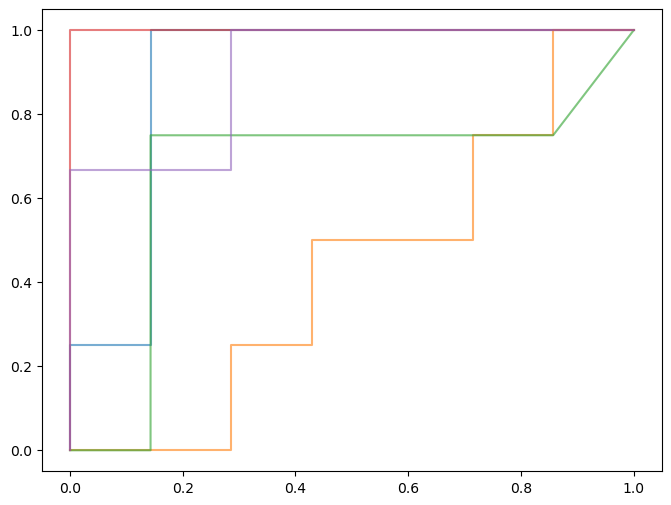

In [33]:
# Outer loop: Statistical evaluation
outer_scores = []

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

# Initialize cumulative confusion matrix values
cumulative_tn, cumulative_fp, cumulative_fn, cumulative_tp = 0, 0, 0, 0

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    cumulative_tn += tn
    cumulative_fp += fp
    cumulative_fn += fn
    cumulative_tp += tp
    
    
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
            "auc": auc(*roc_curve(y_test, y_test_pred_proba)[:2]),
            "kappa": cohen_kappa_score(y_test, y_test_pred),
            "mcc": matthews_corrcoef(y_test, y_test_pred),
            "precision": precision_score(y_test, y_test_pred, average="weighted"),
            "recall": recall_score(y_test, y_test_pred, average="weighted"),

        }
    )


In [31]:
print('best_params:', best_params)

best_params: {'n_estimators': 76, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True}


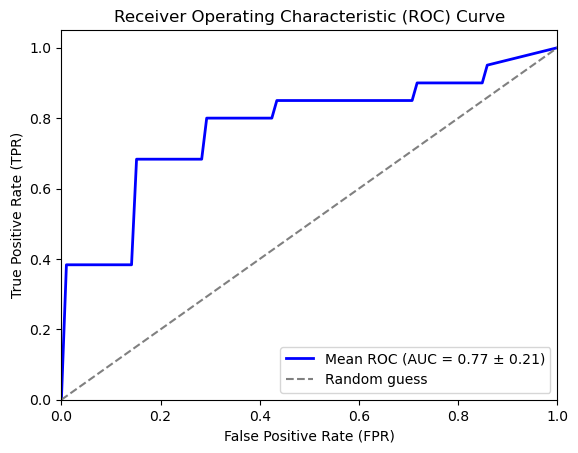

Accuracy: Mean = 0.74, Std = 0.13
F1_score: Mean = 0.72, Std = 0.14
Auc: Mean = 0.78, Std = 0.21
Kappa: Mean = 0.37, Std = 0.30
Mcc: Mean = 0.39, Std = 0.31
Precision: Mean = 0.74, Std = 0.15
Recall: Mean = 0.74, Std = 0.13
Overall Specificity: 0.86
Overall Sensitivity: 0.50
Cumulative TN: 31, FP: 5, FN: 9, TP: 9


In [34]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Calculate overall specificity and sensitivity
overall_specificity = cumulative_tn / (cumulative_tn + cumulative_fp)
overall_sensitivity = cumulative_tp / (cumulative_tp + cumulative_fn)
print(f"Overall Specificity: {overall_specificity:.2f}")
print(f"Overall Sensitivity: {overall_sensitivity:.2f}")

print(
    f"Cumulative TN: {cumulative_tn}, FP: {cumulative_fp}, FN: {cumulative_fn}, TP: {cumulative_tp}"
)
